### `Imports`

In [1]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
import librosa
import librosa.display
import subprocess
import glob
import time
from transformers import ViTFeatureExtractor, ViTModel, BertModel, BertTokenizer
from yt_dlp import YoutubeDL
import whisper

# Custom modules
from modules.linear_transformation import LinearTransformations

# Set the random seed for reproducibility
torch.manual_seed(42)


### `Input Preprocessing`

In [2]:
# List of directories to create under misc/endtoend
directories = [
    "misc/endtoend",
    "misc/endtoend/audio",
    "misc/endtoend/video",
    "misc/endtoend/frames",
    "misc/endtoend/audio_features",
    "misc/endtoend/video_features",
    "misc/endtoend/text_features"
]

# Path to the text.csv file
text_csv_path = "misc/endtoend/text.csv"

# Function to ensure a directory is cleared and recreated
def clear_and_create_directory(directory):
    if os.path.exists(directory):
        # Remove all files and subdirectories within the directory
        for root, dirs, files in os.walk(directory, topdown=False):
            for file in files:
                os.remove(os.path.join(root, file))
            for subdir in dirs:
                os.rmdir(os.path.join(root, subdir))
        # Remove the directory itself
        os.rmdir(directory)
        print(f"Removed existing directory: {directory}")
    
    # Create the directory
    os.makedirs(directory, exist_ok=True)
    print(f"Created directory: {directory}")

# Process each directory
for directory in directories:
    clear_and_create_directory(directory)

# Overwrite or create text.csv
if os.path.exists(text_csv_path):
    os.remove(text_csv_path)
    print(f"Removed existing file: {text_csv_path}")

# Create an empty text.csv
with open(text_csv_path, "w") as f:
    pass
print(f"Created new file: {text_csv_path}")


Removed existing directory: misc/endtoend
Created directory: misc/endtoend
Created directory: misc/endtoend/audio
Created directory: misc/endtoend/video
Created directory: misc/endtoend/frames
Created directory: misc/endtoend/audio_features
Created directory: misc/endtoend/video_features
Created directory: misc/endtoend/text_features
Created new file: misc/endtoend/text.csv


In [3]:
# Load the Dataset
df = pd.read_excel('misc/MM-Trailer_dataset.xlsx')

# turn the IMDBid and URL column into a list
urls = df['URL'].tolist()
ids = df['IMDBid'].tolist()

output_directory = 'misc/endtoend/video'

In [4]:
# User Input
print("Choose an option:")
print("1. Movie Trailer from the dataset (input IMDBid)")
print("2. Movie Trailer not from the dataset (input yt or IMDB link)")

choice = input("Enter your choice (1/2): ")

if choice == "1":
    print("You chose from the dataset")
    IMDBid = input("Enter the IMDBid (eg. tt0974661)")
    
    # Check if the IMDBid exists in the dataset
    if IMDBid in ids:
        index = ids.index(IMDBid)
        url = urls[index]
        print(f"URL for {IMDBid}: {url}")
    else:
        sys.exit(f"IMDBid {IMDBid} not found in the dataset. Program terminated.")
    
elif choice == "2":
    print("You chose not from the dataset")
    url = input("Enter the link (eg. https://www.imdb.com/video/vi852340249/)")
    
else:
    print("Invalid choice. Please enter 1 or 2")
    sys.exit("Program terminated due to invalid input.")

Choose an option:
1. Movie Trailer from the dataset (input IMDBid)
2. Movie Trailer not from the dataset (input yt or IMDB link)
You chose from the dataset
URL for tt0974661: https://www.imdb.com/videoplayer/vi2523529241


In [5]:
# Define the output filename
video_filename = os.path.join(output_directory, f'{IMDBid if choice == "1" else "custom"}.mp4')

# Check if the file already exists
if os.path.exists(video_filename):
    print(f"File {video_filename} already exists. Skipping download.")
else:
    try:
        # Define yt-dlp options
        ydl_opts = {
            'outtmpl': video_filename,
            'format': 'bestvideo+bestaudio/best',
            'merge_output_format': 'mp4',
            'postprocessors': [
                {'key': 'FFmpegVideoConvertor', 'preferedformat': 'mp4'}
            ],
            'noplaylist': True,
            'concurrent_fragments': 20,
            'retries': 10,
            'fragment_retries': 10,
            'http_chunk_size': 50 * 1024 * 1024,
            'sleep_interval_requests': 0,
            'sleep_interval': 0,
            'socket_timeout': 90,
        }

        with YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
        print(f"Download completed: {video_filename}")
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        sys.exit(0)

[imdb] Extracting URL: https://www.imdb.com/videoplayer/vi2523529241
[imdb] 2523529241: Downloading webpage
[imdb] 2523529241: Downloading m3u8 information
[info] 2523529241: Downloading 1 format(s): hls-4842
[hlsnative] Downloading m3u8 manifest
[hlsnative] Total fragments: 15
[download] Destination: misc/endtoend/video/tt0974661.mp4
[download] 100% of   71.56MiB in 00:00:01 at 40.34MiB/s                  
[FixupM3u8] Fixing MPEG-TS in MP4 container of "misc/endtoend/video/tt0974661.mp4"
[VideoConvertor] Not converting media file "misc/endtoend/video/tt0974661.mp4"; already is in target format mp4
Download completed: misc/endtoend/video/tt0974661.mp4


### `File Extraction`

#### `Audio`

In [6]:
def convert(video_filepath, audio_filepath):
    # Check if the audio file already exists, and if so, remove it to overwrite
    if os.path.exists(audio_filepath):
        print(f"Audio file {audio_filepath} already exists. Overwriting...")
        os.remove(audio_filepath)
    
    # Command to convert video to audio
    command = "ffmpeg -i {} -vn -ar 44100 -ac 2 -b:a 192k {}".format(video_filepath, audio_filepath)
    
    # Execute the command
    subprocess.call(command, shell=True)
    print(f"Audio conversion completed: {audio_filepath}")

In [7]:
video_dir = "misc/endtoend/video"
audio_dir = "misc/endtoend/audio"
spectrogram_dir = "misc/endtoend/audio"

contents = glob.glob(os.path.join(video_dir, "*.mp4"))
contents_spec = glob.glob(os.path.join(spectrogram_dir, "*.png"))

print("Contents of the directory: ")
for item in contents:
    print(item)

for item in contents_spec:
    print(item)

Contents of the directory: 
misc/endtoend/video/tt0974661.mp4


Processing videos:   0%|          | 0/1 [00:00<?, ?it/s]


Converting video to audio for tt0974661.mp4...


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

Audio conversion completed: misc/endtoend/audio/tt0974661.mp3
Conversion took 1.36 seconds
Loading audio...
Loading audio took 0.88 seconds
Converting to Mel Spectrogram...
Mel Spectrogram conversion took 0.14 seconds
Converting to Log-Mel Spectrogram...
Log-Mel Spectrogram conversion took 0.01 seconds
Visualizing Log-Mel Spectrogram...


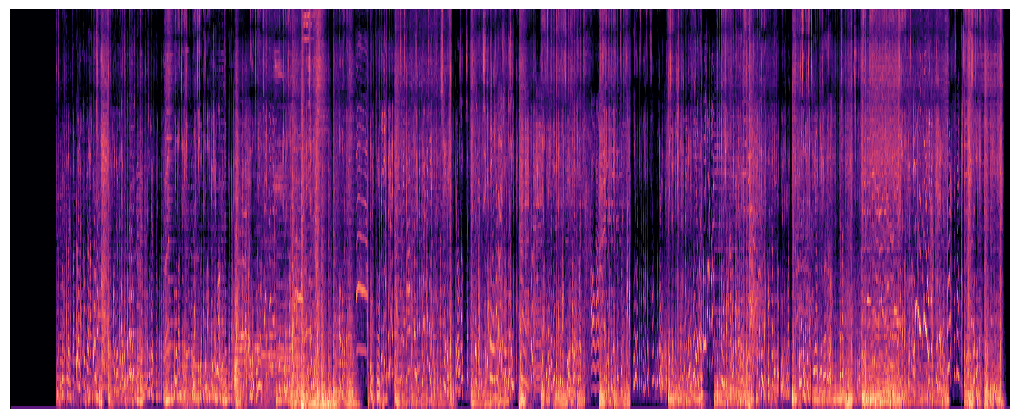

Processing videos: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]

Visualization and saving took 0.84 seconds
Deleted audio file misc/endtoend/audio/tt0974661.mp3
Total processing time for tt0974661.mp4: 3.23 seconds


<Figure size 640x480 with 0 Axes>

In [8]:
for video_file in tqdm(glob.glob(os.path.join(video_dir, "*.mp4")), desc="Processing videos"):
    start_time = time.time()

    audio_file = os.path.join(audio_dir, os.path.basename(video_file).replace(".mp4", ".mp3"))

    # Convert video to audio
    print(f"\nConverting video to audio for {os.path.basename(video_file)}...")
    convert_start_time = time.time()
    convert(video_file, audio_file)
    print(f"Conversion took {time.time() - convert_start_time:.2f} seconds")

    # Load audio
    print("Loading audio...")
    load_start_time = time.time()
    y, sr = librosa.load(audio_file, sr=None)
    print(f"Loading audio took {time.time() - load_start_time:.2f} seconds")

    # Convert to Mel Spectrogram
    print("Converting to Mel Spectrogram...")
    mel_start_time = time.time()
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    print(f"Mel Spectrogram conversion took {time.time() - mel_start_time:.2f} seconds")

    # Convert to Log-Mel Spectrogram
    print("Converting to Log-Mel Spectrogram...")
    logmel_start_time = time.time()
    log_S = librosa.power_to_db(S, ref=np.max)
    print(f"Log-Mel Spectrogram conversion took {time.time() - logmel_start_time:.2f} seconds")

    # Visualize
    print("Visualizing Log-Mel Spectrogram...")
    visualize_start_time = time.time()
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_S, sr=sr, x_axis=None, y_axis=None, fmax=8000)
    plt.axis('off') 
    plt.tight_layout(pad=0)
    fig1 = plt.gcf()
    plt.show()
    plt.draw()

    # Save
    spectrogram_file = os.path.join(spectrogram_dir, os.path.basename(video_file).replace(".mp4", ".png"))
    fig1.savefig(spectrogram_file, bbox_inches='tight', pad_inches=0)
    plt.close(fig1)
    print(f"Visualization and saving took {time.time() - visualize_start_time:.2f} seconds")

    # Delete the MP3 audio file after processing
    if os.path.exists(audio_file):
        os.remove(audio_file)
        print(f"Deleted audio file {audio_file}")

    total_time = time.time() - start_time
    print(f"Total processing time for {os.path.basename(video_file)}: {total_time:.2f} seconds")


#### `Text`

In [9]:
# Path to save the CSV file in Google Drive
csv_file = 'misc/endtoend/text.csv'

# Initialize Whisper model (assuming 'model' is initialized elsewhere in your code)
model = whisper.load_model("base")  # Adjust model type as necessary

# Open CSV file in append mode to add new transcriptions
with open(csv_file, "a", newline="", encoding="utf-8") as csvfile:
    csv_writer = csv.writer(csvfile)
    
    # Check if the CSV is empty (i.e., no headers exist) and write headers if needed
    if os.stat(csv_file).st_size == 0:
        csv_writer.writerow(['Video File', 'Transcription'])  # Write header row

    try:
        # Transcribe the single video file
        result = model.transcribe(video_filename)

        # Extract the transcribed text from the result dictionary
        transcribed_text = result['text']

        # Write filename and transcription to CSV
        csv_writer.writerow([os.path.basename(video_filename), transcribed_text])

        print(f"Transcription for {video_filename} saved to CSV")
        
    except Exception as e:
        # Handle any errors that occur during transcription
        print(f"Error processing {video_filename}: {str(e)}")

print(f"Transcription saved to {csv_file}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.loa

Transcription for misc/endtoend/video/tt0974661.mp4 saved to CSV
Transcription saved to misc/endtoend/text.csv


#### `Video`

In [10]:
# Create folders for frames
frames_path = 'misc/endtoend/frames/'

In [11]:
def video_to_frames(file_path, file_name, target_fps=20):

    # Remove the .mp4 extension from the file name to use it for folder creation
    file_name_without_extension = os.path.splitext(file_name)[0]

    # Open video file
    cam = cv2.VideoCapture(file_path)

    # Check if the video opened successfully
    if not cam.isOpened():
        print(f"Error: Could not open video {file_name}")
        return

    # Get the original FPS of the video
    original_fps = cam.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps // target_fps)

    # Create folder for the current video frames (without .mp4 extension)
    save_folder = os.path.join(frames_path, file_name_without_extension)
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Initialize index
    current_frame = 0
    saved_frame = 0

    while(True):
        # grabs frame, if failed sets ret = false 
        ret, frame = cam.read()
        
        if not ret:
            break
        # Only save every 'frame_interval' frame to match the target FPS
        if current_frame % frame_interval == 0:
            save_path = os.path.join(save_folder, f'{saved_frame}.jpg')
            
            # Save the frame
            saved = cv2.imwrite(save_path, frame)
            if not saved:
                print(f"Failed to save {saved_frame}: {save_path}")
            
            saved_frame += 1
        current_frame += 1

    cam.release()
    print(f"{file_name_without_extension}: Success frames conversion!")


In [12]:
video_to_frames(video_filename, os.path.basename(video_filename), target_fps=1)

tt0974661: Success frames conversion!


### `Feature Extraction`

#### `Audio`

In [13]:
log_mel_spectrograms_path = "misc/endtoend/audio"
output_path = "misc/endtoend/audio_features"

In [14]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [15]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
model.eval()

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [16]:
def process_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_token_features = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    print(f"Processed {image_path} with feature shape: {last_token_features.shape}")
    return last_token_features

In [17]:
def extract_features(input_path, output_path, feature_suffix=""):
    image_files = [f for f in os.listdir(input_path) if f.endswith(".png") or f.endswith(".jpg")]
    
    for filename in tqdm(image_files):
        image_path = os.path.join(input_path, filename)
        feature_vector = process_image(image_path)
        base_filename = os.path.splitext(filename)[0]
        output_file = os.path.join(output_path, f"feature_{base_filename}{feature_suffix}.npy")

        np.save(output_file, feature_vector)


In [18]:
extract_features(log_mel_spectrograms_path, output_path)

100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

Processed misc/endtoend/audio/tt0974661.png with feature shape: (768,)


#### `Text`

In [19]:
# Initialize BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained('bert-large-uncased')

def extract_features(transcript):
    inputs = tokenizer(transcript, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    # Extract the hidden state of the [CLS] token (index 0)
    cls_hidden_state = last_hidden_states[:, 0, :].squeeze().cpu().numpy()
    return cls_hidden_state

# Ensure the feature_vectors directory exists
output_dir = 'misc/endtoend/text_features'
os.makedirs(output_dir, exist_ok=True)

# Read CSV file
csv_file = 'misc/endtoend/text.csv'
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    print(f"Error: The file {csv_file} was not found.")
    exit()
except Exception as e:
    print(f"Error: An error occurred while reading {csv_file}: {e}")
    exit()

# Check if required columns exist
required_columns = ['Video File', 'Transcription']
if not all(col in df.columns for col in required_columns):
    print(f"Error: The file {csv_file} does not contain the required columns: {required_columns}")
    exit()

# Create an empty list to store identifiers
identifiers = []

# Iterate through each transcript in the DataFrame
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing transcripts"):
    identifier = row['Video File']
    transcript = row['Transcription']
    
    try:
        # Extract features for the current transcript
        feature_vector = extract_features(transcript)
        
        # Save the feature vector as a NumPy array
        identifier = os.path.splitext(identifier)[0]  # Remove the .mp4 extension from the video file column 
        np.save(os.path.join(output_dir, f'{identifier}.npy'), feature_vector)
        
        # Optionally, keep track of identifiers for reference
        identifiers.append(identifier)
    except Exception as e:
        print(f"Error: An error occurred while processing {identifier}: {e}")

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

#### `Video`

In [20]:
#load the feature extractor and the model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [21]:
frames_dir = 'misc/endtoend/frames'
features_dir = 'misc/endtoend/video_features'

In [22]:
# Function to extract features from a single image
def extract_features(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

In [23]:
# Loop over each video folder
for video_folder in os.listdir(frames_dir):
    video_folder_path = os.path.join(frames_dir, video_folder)
    if os.path.isdir(video_folder_path):
        features = []
        # Loop over each frame in the video folder
        for frame_file in os.listdir(video_folder_path):
            frame_path = os.path.join(video_folder_path, frame_file)
            if frame_file.endswith(('.png', '.jpg', '.jpeg')):  # Adjust based on your frame file types
                feature = extract_features(frame_path)
                features.append(feature)
        
        # Convert the list of features to a numpy array
        features_array = np.stack(features)
        
        # Save the features array as a .npy file
        save_path = os.path.join(features_dir, f"{video_folder}_features.npy")
        np.save(save_path, features_array)
        print(f"Saved features for {video_folder} to {save_path}")

Saved features for tt0974661 to misc/endtoend/video_features/tt0974661_features.npy


### `SMCA`

#### `Hyperparameters and Assignment`

In [24]:
# Define all possible modality assignments
modality_configurations = {
    'ATV': {
        'modalityAlpha': 'audio_features',
        'modalityBeta': 'text_features',
        'modalityGamma': 'video_features'
    },
    'AVT': {
        'modalityAlpha': 'audio_features',
        'modalityBeta': 'video_features',
        'modalityGamma': 'text_features'
    },
    'TVA': {
        'modalityAlpha': 'text_features',
        'modalityBeta': 'video_features',
        'modalityGamma': 'audio_features'
    }
}

# Function to get the modality assignments by configuration name
def get_modality_assignments(config_name):
    if config_name in modality_configurations:
        return modality_configurations[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found.")
    
    
# Define possible configurations for audio feature directories
audio_feature_paths = {
    'logmel': '../misc/endtoend/audio_features/',
    'mfcc': '../misc/audio_features/mfcc'
}

# Function to get the audio feature path based on the selected configuration
def get_audio_feature_path(config_name):
    if config_name in audio_feature_paths:
        return audio_feature_paths[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found. Available options: logmel, mfcc.")

In [25]:
### Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### Modality Assignment: 'ATV', 'AVT', 'TVA'
selected_modality = 'AVT'
modality_assignments = get_modality_assignments(selected_modality)

### Audio Feature selection: 'logmel' or 'mfcc'
selected_audio_feature = 'logmel'
audio_features_dir = get_audio_feature_path(selected_audio_feature)

#FIXED CONSTANT
max_pad = 197

### Hyperparameters
threshold = 0.5              # for predictions
cl_dropout_rate = 0.4        # for FinalClassifier
att_dropout_rate = 0.4       # for MutualCrossAttention
output_dim = 768

Device: cpu


#### `SMCA Model Class and Functions`

In [26]:
# MCA Class
class MutualCrossAttention(nn.Module):
    def __init__(self, dropout, device):
        super(MutualCrossAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(768).to(device)
        self.device = device

    def forward(self, x1, x2):
        # Move x1 and x2 to the correct device
        x1, x2 = x1.to(self.device), x2.to(self.device)

        # Query and key
        query = x1
        key = x2
        d = query.shape[-1]

        # Basic attention mechanism
        scores = torch.matmul(query, key.T) / math.sqrt(d)
        output_A = torch.matmul(self.dropout(F.softmax(scores, dim=-1)), x2)
        scores = torch.matmul(key, query.T) / math.sqrt(d)
        output_B = torch.matmul(self.dropout(F.softmax(scores, dim=-1)), x1)

        # Combine outputs
        output = output_A + output_B
        output = self.layer_norm(output)

        return output

In [27]:
def SMCAStage1(modalityAlpha, modalityBeta, d_out_kq, d_out_v, device):
    
    cross_attn = MutualCrossAttention(att_dropout_rate, device=device)

    # Cross-attention: Alpha + Beta
    alphaBeta = cross_attn(modalityAlpha, modalityBeta)  # Shape: (batch_size, num_queries, d_out_v)

    # Concatenate cross-attention outputs along the feature dimension (-1)
    return alphaBeta

In [28]:
def SMCAStage2(modalityAlphaBeta, modalityGamma, d_out_kq, d_out_v, device):
    # modalityAlphaBeta: (batch_size, seq_len, 2 * d_out_v) [output of Stage 1]

    cross_attn = MutualCrossAttention(att_dropout_rate, device=device)

    alphaBetaGamma = cross_attn(modalityAlphaBeta, modalityGamma)  # Shape: (batch_size, seq_len_alphaBeta, d_out_v)

    return alphaBetaGamma

In [29]:
class SMCAModel(nn.Module):
    def __init__(self, d_out_kq, d_out_v, device):
        super(SMCAModel, self).__init__()
        self.d_out_kq = d_out_kq
        self.d_out_v = d_out_v
        self.device = device
    
    def forward(self, modalityAlpha, modalityBeta, modalityGamma):
        # Stage 1: Cross attention between modalityAlpha and modalityBeta
        modalityAlphaBeta = SMCAStage1(modalityAlpha, modalityBeta, self.d_out_kq, self.d_out_v, self.device)

        # Stage 2: Cross attention with modalityAlphaBeta (as query) and modalityGamma (as key-value)
        multimodal_representation = SMCAStage2(modalityAlphaBeta, modalityGamma, self.d_out_kq, self.d_out_v, self.device)

        return multimodal_representation

In [30]:
def pad_features(features, max_pad=max_pad):
    # Pad or trim the sequence dimension to `max_pad`
    if features.size(0) < max_pad:
        # Pad to the right along the sequence dimension
        features = F.pad(features, (0, 0, 0, max_pad - features.size(0)))
    elif features.size(0) == max_pad:
        pass
    else:
        # Trim if the sequence is longer than `max_pad`
        features = features[:, :max_pad, :]
        print("VIDEO TRIMMED SOMETHING MAY MALI")
    return features

#### `Feature Fusion`

In [31]:
# Directories containing the .npy files
audio_features_dir = 'misc/endtoend/audio_features'
text_features_dir = 'misc/endtoend/text_features'
video_features_dir = 'misc/endtoend/video_features'

# Get the .npy file in each directory (assuming only one file exists in each)
audio_file_path = glob.glob(os.path.join(audio_features_dir, "*.npy"))[0]
text_file_path = glob.glob(os.path.join(text_features_dir, "*.npy"))[0]
video_file_path = glob.glob(os.path.join(video_features_dir, "*.npy"))[0]

# Load the .npy files
audio_features = np.load(audio_file_path)
text_features = np.load(text_file_path)
video_features = np.load(video_file_path)

# Convert into tensors
audio_features = torch.from_numpy(audio_features).float()
text_features = torch.from_numpy(text_features).float()
video_features = torch.from_numpy(video_features).float()

# Squeeze the audio features to remove the extra dimension
audio_features = audio_features.unsqueeze(0).to(device) 
text_features = text_features.unsqueeze(0).to(device) 

# Apply linear transformations to match dimensions
linear_transform_text = LinearTransformations(text_features.shape[-1], 768).to(device)    
text_features = linear_transform_text(text_features).to(device) 

audio_features = audio_features[-1, :].unsqueeze(0).to(device)   # Resulting shape: [batch_size, 1, 768]

video_features = pad_features(video_features).to(device)   # Shape will be [batch_size, max_pad, 768]

transformed_features = {
            'audio_features': audio_features,
            'text_features': text_features,
            'video_features': video_features
        }

model = SMCAModel(768, 768, device).to(device)  # Dimension for d_out_kq and d_out_v

outputs = model(
    modalityAlpha=transformed_features[modality_assignments['modalityAlpha']].to(device) ,  # Use the dictionary for modality assignment
    modalityBeta=transformed_features[modality_assignments['modalityBeta']].to(device) ,
    modalityGamma=transformed_features[modality_assignments['modalityGamma']].to(device) 
).to(device)

outputs = outputs.view(-1)  

### `Classification`

In [32]:
class FinalClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=cl_dropout_rate):
        super(FinalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 3072)  # First fully connected layer
        self.fc2 = nn.Linear(3072, 768)          # Second fully connected layer
        # self.fc3 = nn.Linear(768, 128)          # Third fully connected layer
        # self.fc4 = nn.Linear(128, 64)          # Second fully connected layer

        self.dropout = nn.Dropout(dropout_rate) # Dropout layer
        self.dense = nn.Linear(768, 1)          # Final dense layer for binary classification
        self.relu = nn.ReLU()                    # ReLU activation
        self.sigmoid = nn.Sigmoid()              # Sigmoid activation for final output

    def forward(self, x):
        x = self.fc1(x)                         # First fully connected layer
        x = self.relu(x)                        # Apply ReLU activation

        x = self.fc2(x)                         # second fully connected layer
        x = self.relu(x)                        # Apply ReLU activation
        x = self.dropout(x)                     # Apply dropout
        
        # x = self.fc3(x)                         # third fully connected layer
        # x = self.relu(x)                        # Apply ReLU activation

        # x = self.fc4(x)                         # fourth fully connected layer
        # x = self.relu(x)                        # Apply ReLU activation
        # x = self.dropout(x)                     # Apply dropout
        
        x = self.dense(x)                       # Final dense layer
        x = self.sigmoid(x)                  # Apply sigmoid activation
        return x                                 # Output probabilities for BCELoss


In [33]:
# Pass the fused features through the dense layer
dense_layer = FinalClassifier(output_dim * max_pad).to(device)

# Load the pretrained classifier
# weights_path = 'misc/model_weights.pth'
# state_dict = torch.load(weights_path)
# dense_layer.load_state_dict(state_dict)

predictions = dense_layer(outputs).view(-1)

### `Results`

In [34]:
print('Prediction:\t', predictions[0].item())

if predictions[0].item() >= threshold:
    print('Predicted Label:', 'red')
else:
    print('Predicted Label:', 'green')

df = pd.read_excel('misc/MM-Trailer_dataset.xlsx')

# if in the dataset or not
if choice == '1':
    label = df.loc[df['IMDBid'] == video_folder, 'Label'].values
    print('True Label:\t', label[0])
else:
    print('Not in the dataset, no information about the true label.')

Prediction:	 0.5329590439796448
Predicted Label: red
True Label:	 green
